In [3]:
#required dependencis
!pip install  langchain langchain-core langchain-community langchain-groq langchain-text-splitters langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 18.3 MB/s eta 0:00:00


In [5]:
#load document
import bs4
from langchain_community.document_loaders import WebBaseLoader

#only keep title, headers, and content from the full html
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [7]:
#Splitting documents
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap= 200,
    add_start_index = True,
)
all_splits = text_splitter.split_documents(docs)
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [10]:
#Embeddings
!pip install -qU langchain-huggingface
from langchain_huggingface import HunggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-mpnet-base-v2")
vector_1 = embeddings.embed_query(all_splits[0].page_content)
vector_2 = embeddings.embed_query(all_splits[1].page_content)

assert len(vector_1) == len(vector_2)
print(f"Generated vector of length {len(vector_1)}\n")
print(vector_1[:10])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generated vector of length 768

[0.021580325439572334, 0.014582928270101547, -0.03646112605929375, 0.029159609228372574, -0.04921048507094383, 0.012522578239440918, -0.04396882653236389, 0.018793204799294472, 0.03727596253156662, -0.034498490393161774]


In [12]:
#Vector stores
from langchain_core.vectorstores import InMemoryVectorStore
vector_store = InMemoryVectorStore(embeddings)

#Storing documents
document_ids = vector_store.add_documents(documents = all_splits)
print(document_ids[:3])

['34091df1-a00d-41c2-ad1d-c569ef79e42e', 'cbfd3abd-8937-41c1-ba77-de8bb3e40b86', 'daa192e6-f591-4eeb-bae5-08271e51f5ce']


In [14]:
#llm initialize
from google.colab import userdata
GROQ_API_KEY = userdata.get("GROQ_API_KEY")
if GROQ_API_KEY is None:
  raise ValueError("Set valid API KEY")
from langchain.chat_models import init_chat_model
llm = init_chat_model(groq_api_key = GROQ_API_KEY, model="meta-llama/llama-4-scout-17b-16e-instruct", model_provider = "groq")

In [27]:
#Retrieval and Generation
from langgraph.graph import StateGraph
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage # Import necessary message types

graph_builder = StateGraph(list) # Define state as a list of messages

from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: list): # Use list as type hint for state
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state) # Pass the state (list of messages) directly
    return state + [response] # Append the new message to the state


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: list): # Use list as type hint for state
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state): # Iterate over the list of messages
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    # Filter out tool messages from the conversation history for the final prompt
    conversation_messages = [
        message
        for message in state
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return state + [response] # Append the new message to the state


from langgraph.graph import END
from langgraph import prebuilt # Import prebuilt for tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    prebuilt.tools_condition, # Use tools_condition from prebuilt
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

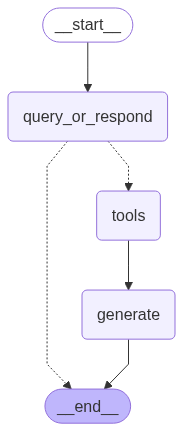

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
from langchain_core.messages import HumanMessage # Import HumanMessage

input_message = "What is Task Decomposition?"

# Pass initial messages as a list of HumanMessage objects
initial_messages = [HumanMessage(content=input_message)]

for step in graph.stream(
    initial_messages, # Pass initial messages as a list of HumanMessage objects
    stream_mode="values",
):
    # Access the last message in the list
    if isinstance(step, dict) and "messages" in step and step["messages"]:
        last_message = step["messages"][-1]
        # Check if the last message is a tuple and convert it to a HumanMessage if it's a user message
        if isinstance(last_message, tuple) and last_message[0] == "user":
            last_message = HumanMessage(content=last_message[1])
        last_message.pretty_print()
    elif isinstance(step, list) and step:
        last_message = step[-1]
        # Check if the last message is a tuple and convert it to a HumanMessage if it's a user message
        if isinstance(last_message, tuple) and last_message[0] == "user":
            last_message = HumanMessage(content=last_message[1])
        last_message.pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

Task decomposition is a process of breaking down a complex task into smaller, more manageable sub-tasks. This technique is used to simplify complex problems, making them easier to understand, analyze, and solve. By decomposing a task into smaller sub-tasks, individuals or teams can focus on one sub-task at a time, reducing the complexity and increasing the chances of successful completion.

Task decomposition involves identifying the main task, analyzing its components, and then breaking it down into smaller, independent sub-tasks. Each sub-task should have a clear objective, and the completion of all sub-tasks should ultimately lead to the completion of the main task.

The benefits of task decomposition include:

1. **Reduced complexity**: Breaking down a complex task into smaller sub-tasks makes

In [36]:
#Stateful management of chat histor
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage # Import HumanMessage

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

input_message = "What is Task Decomposition?"

for step in graph.stream(
    [HumanMessage(content=input_message)], # Pass initial messages as a list of HumanMessage objects
    stream_mode="values",
    config=config,
):
    # Access the last message in the list
    if isinstance(step, dict) and "messages" in step and step["messages"]:
        last_message = step["messages"][-1]
        # Check if the last message is a tuple and convert it to a HumanMessage if it's a user message
        if isinstance(last_message, tuple) and last_message[0] == "user":
            last_message = HumanMessage(content=last_message[1])
        last_message.pretty_print()
    elif isinstance(step, list) and step:
        last_message = step[-1]
        # Check if the last message is a tuple and convert it to a HumanMessage if it's a user message
        if isinstance(last_message, tuple) and last_message[0] == "user":
            last_message = HumanMessage(content=last_message[1])
        last_message.pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

Task decomposition is the process of breaking down a complex task into smaller, more manageable sub-tasks. This technique is used to simplify complex problems, making them easier to understand, analyze, and solve. By decomposing a task into smaller sub-tasks, individuals can focus on one sub-task at a time, reducing feelings of overwhelm and increasing productivity.

Task decomposition involves identifying the main task or goal and then recursively breaking it down into smaller sub-tasks, until each sub-task is simple enough to be accomplished. The sub-tasks are often organized in a hierarchical structure, with the main task at the top and the sub-tasks branching out below it.

The benefits of task decomposition include:

1. **Improved clarity**: Breaking down a complex task into smaller sub-tasks

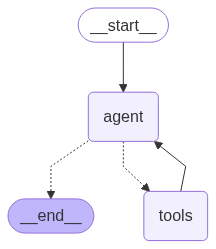

In [37]:
#Agents
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [38]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================

The standard method for Task Decomposition is called the "Hierarchical Task Decomposition" or "Task Tree" method. 

In this method, a complex task is broken down into smaller, more manageable sub-tasks, which are then further decomposed into even smaller sub-tasks until the entire task is represented as a hierarchical tree of tasks. 

This method helps to identify the key components of a task, their relationships, and the required resources and skills to accomplish each sub-task.

Some common extensions of the Hierarchical Task Decomposition method include:

*  **Functional Decomposition**: This involves breaking down a task into smaller sub-tasks based on their functional requirements.
*  **Temporal Decomp